## Classificação de dados desbalanceados

Quando estamos lidando com um problema de classificação ficamos tentados a ir direto para a construção do modelo, definir as métricas de validação e começar as predições. Porém, um passo muito importante que não deve ser negligenciado é entendermos os dados que temos. Para isso nós devemos fazer uma análise exploratória dos dados, e no caso de classificação, devemos analisar se os dados são balanceados ou não. 
Numa análise de classificação binária, um dado é considerado desbalanceado se o quantidade de dado de uma classe for muito maior que de outra. Este desbalanceamento gera um viés no nosso modelo, que é exposto a uma maior quantidade de dados de uma classe em detrimento da outra. Por exemplo, quando estudamos um vírus raro, teremos mais dados de pacientes que testaram negativo para o vírus do que para positivo. 
Um ponto importante quando lidamos com dados deste tipo é saber qual a prioridade que devemos dar para cada classe. Pois, no nosso exemplo, se a nossa prioridade é identificar o máximo de pacientes com a doença, precisaremos tratar os dados para que quando for gerado as predições, o modelo dê "mais ênfase" em identificar positivos, mesmo que tenhamos que lidar com alguns falso positivos. eralmente é considerado desbalanceado, classes com relação de 3/10 ou 1/10.

Neste notebook abordaremos os dados de pacientes que foram testado para saber se tem ou não diabetes.

In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, make_scorer, f1_score

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
p = df['Outcome'].value_counts()[1]/(df['Outcome'].value_counts()[0]+df['Outcome'].value_counts()[1])

print('Proporção de pacientes positivo para diabetes %', (p*100))

Proporção de pacientes positivo para diabetes % 34.89583333333333


Esta desproporção de dados para uma classe não é tão desbalanceada. Mas ainda sim, poderá se beneficiar de algumas das técnicas de compensação de desproporção do dados.

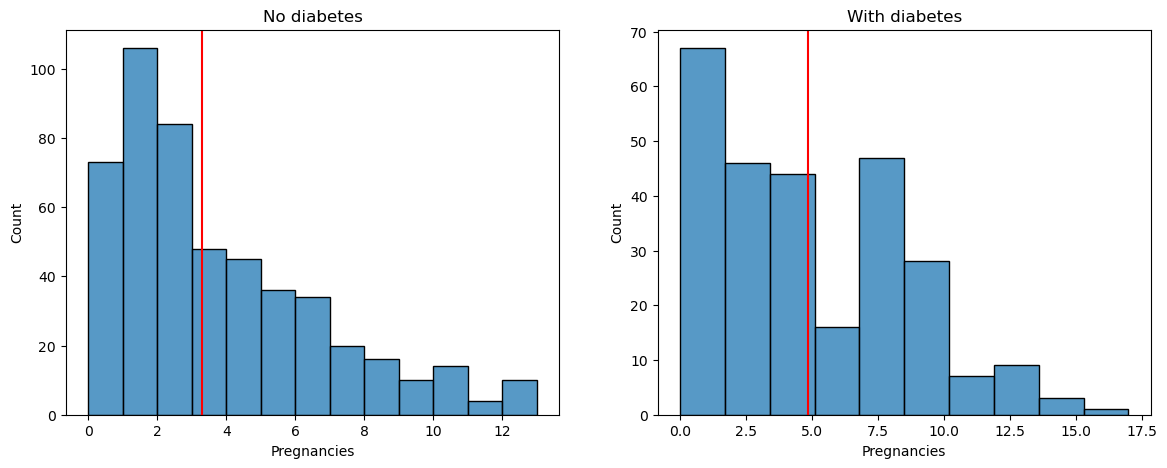

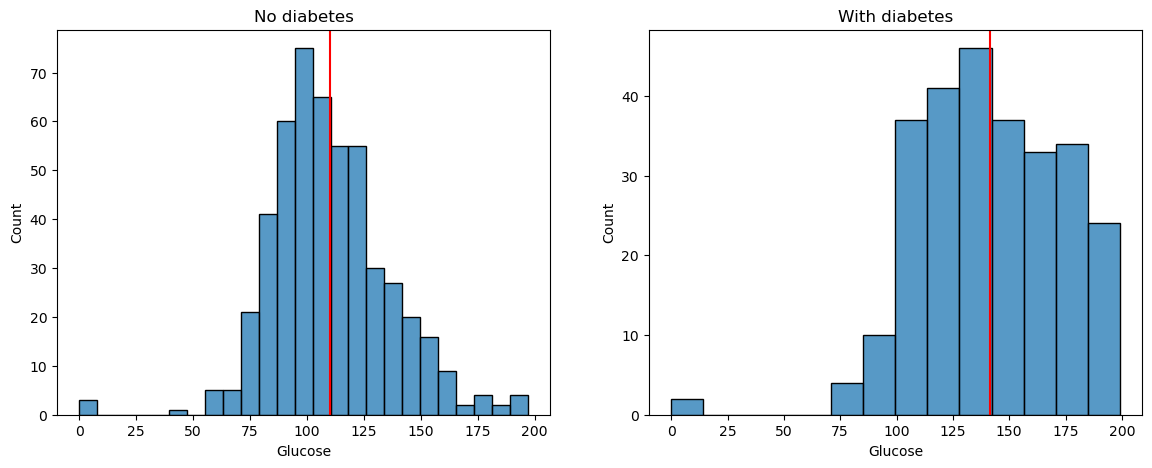

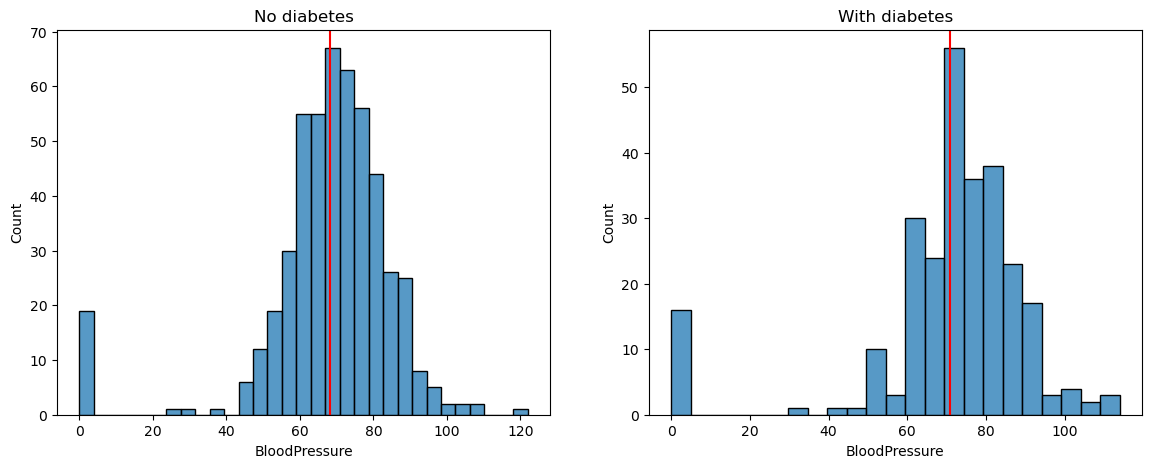

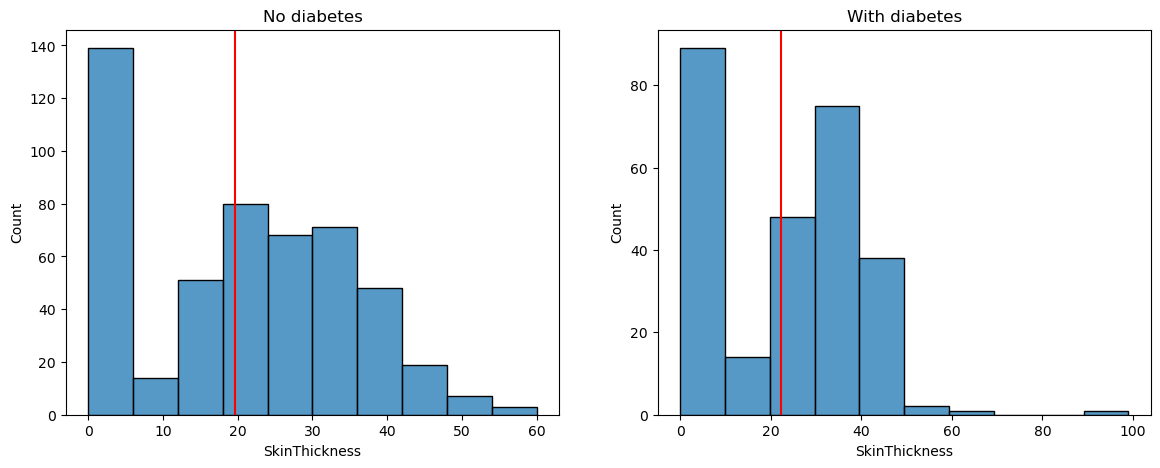

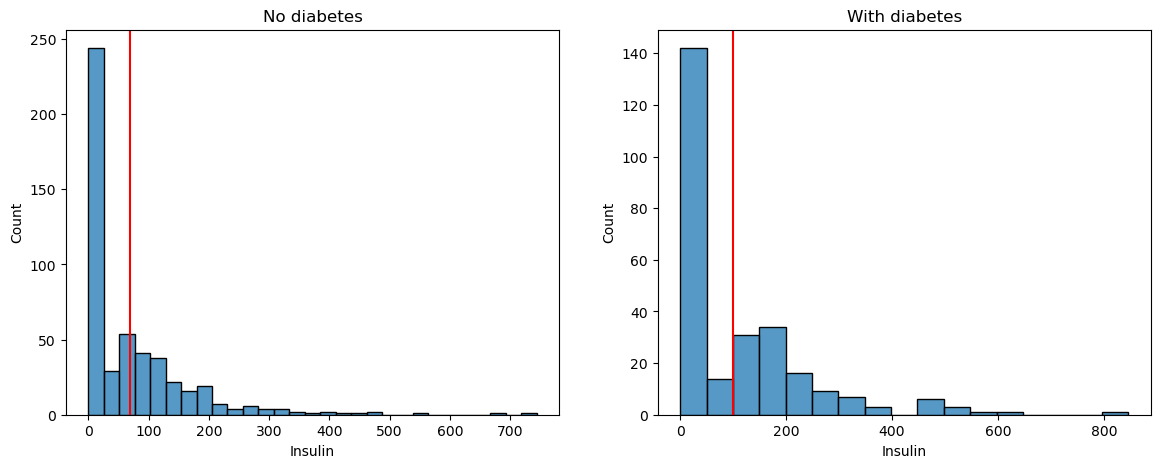

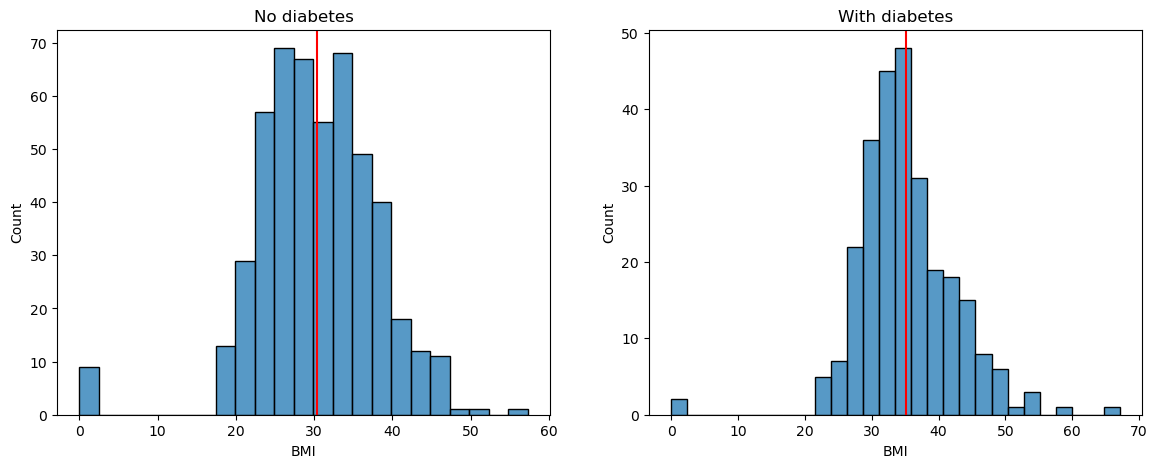

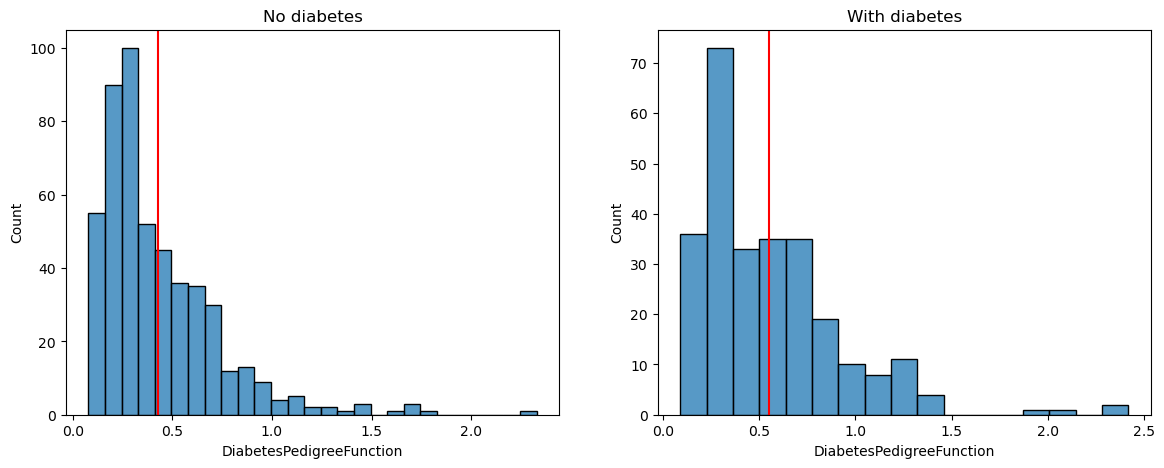

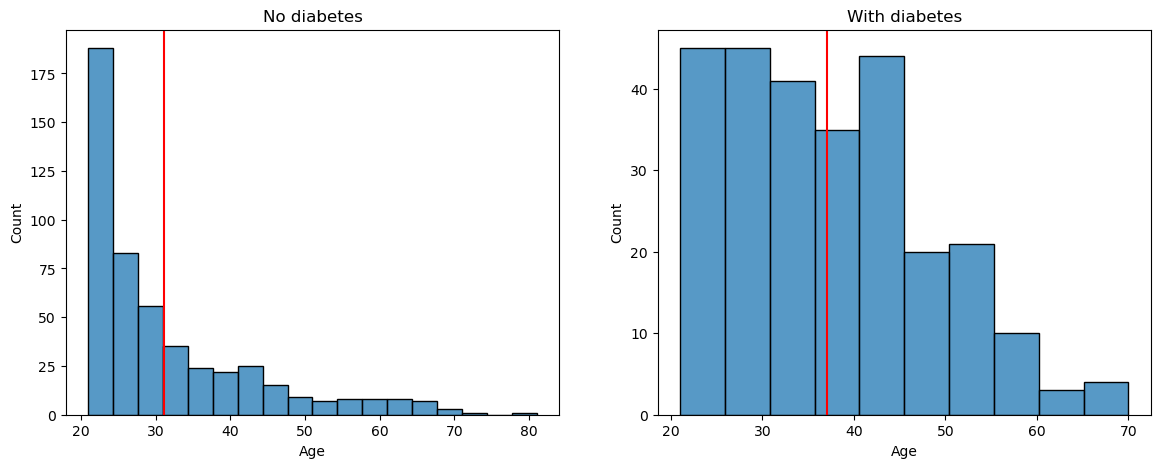

In [5]:
# Distribuição para cada classe por variável indepentente:

for i in np.arange(0,8):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
    sns.histplot(df[df['Outcome']==0].iloc[:,i],ax=axes[0])
    axes[0].axvline(df[df['Outcome'] == 0].iloc[:, i].mean(), color='red')
    axes[0].set_title("No diabetes")
    sns.histplot(df[df['Outcome']==1].iloc[:,i],ax=axes[1])
    axes[1].axvline(df[df['Outcome'] == 1].iloc[:, i].mean(), color='red')
    axes[1].set_title("With diabetes")
    plt.show()

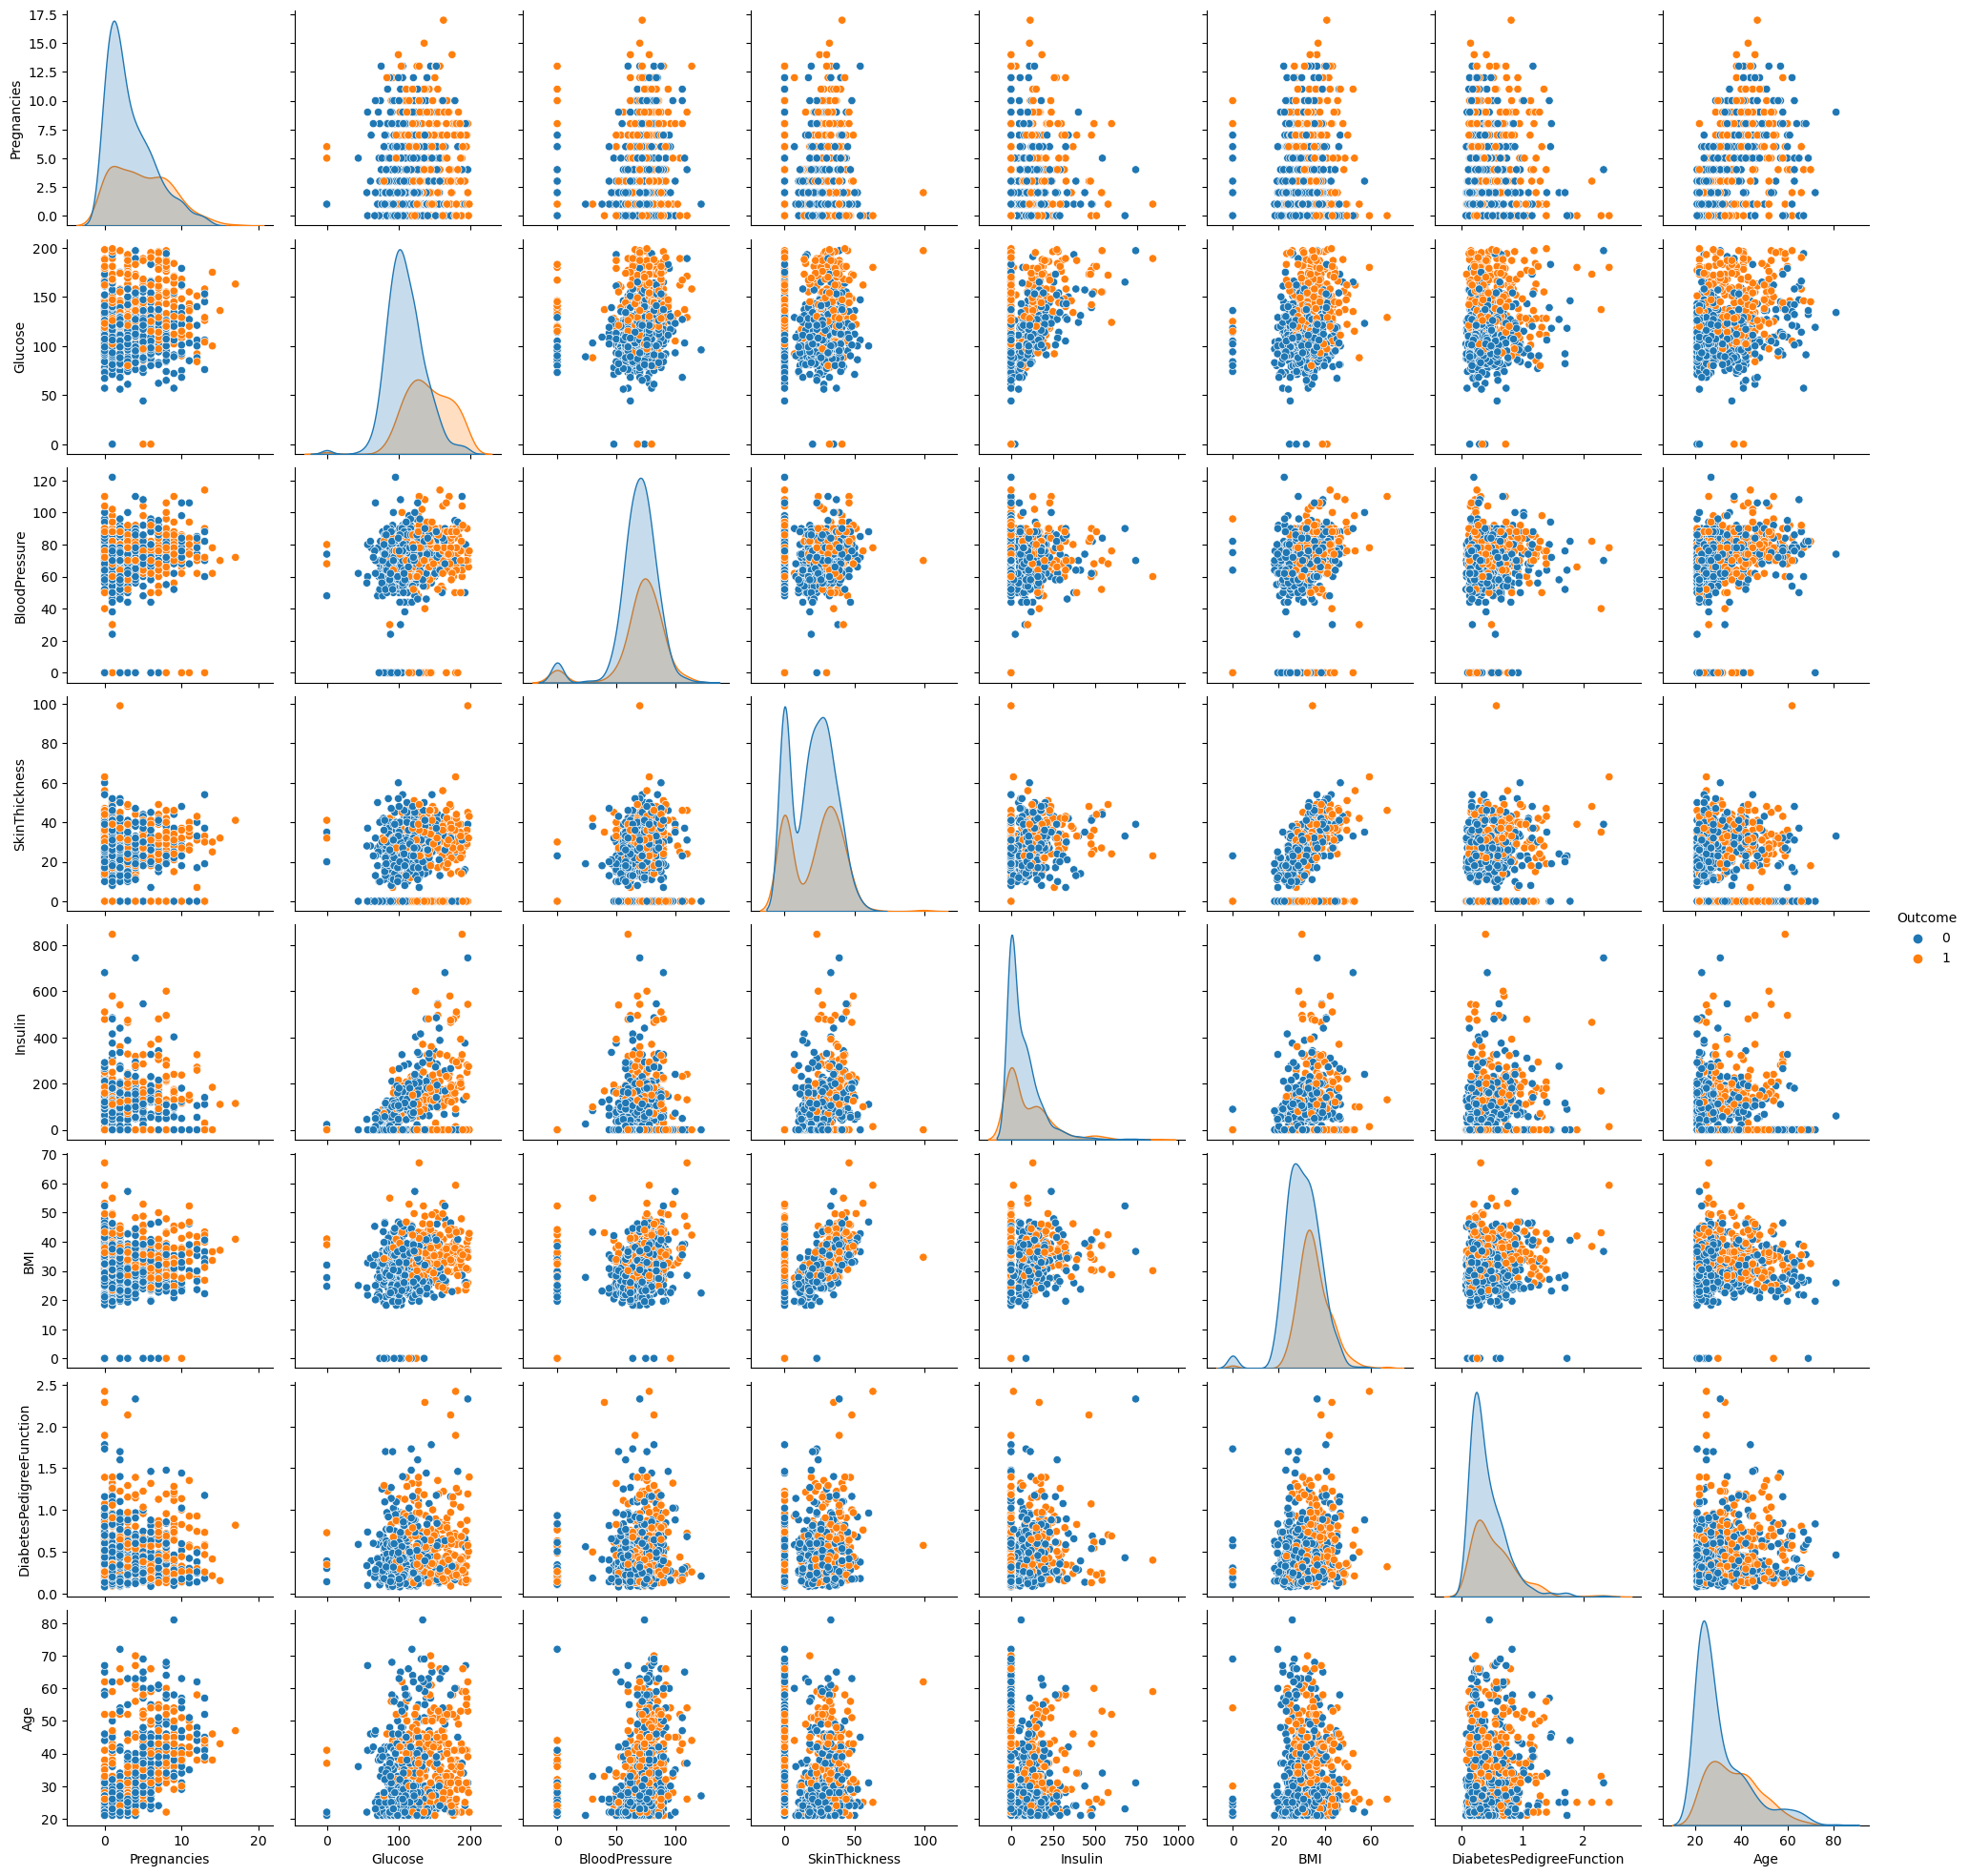

In [6]:
sns.pairplot(df, hue='Outcome')

In [7]:
y = df['Outcome'].apply(lambda x: 'negative' if x==0 else 'positive')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:8], y, test_size=0.3, random_state=1)

In [9]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1)

In [10]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [11]:
preds = rfc.predict(X_test)

In [12]:
#Variáveis por ordem de importância no modelo
pd.DataFrame(index=X_train.columns,data=rfc.feature_importances_,
            columns= ['Feature Importance']).sort_values('Feature Importance',ascending=False)

,Feature Importance
Glucose,0.240239
BMI,0.176087
DiabetesPedigreeFunction,0.131283
Age,0.131015
BloodPressure,0.098011
Pregnancies,0.084230
Insulin,0.069930
SkinThickness,0.069204


Como era de se esperar no caso de diabetes, glucose é uma das principais variáveis para explicar a diabetes, sendo 24% do modelo.

Uma das melhores ferramentas que temos para verificar um modelo de classificação é a *confusion matrix*. Quando batemos o olho nela, já conseguimos entender como nosso modelo se saiu para classificar tanto positivo como negativo e o que precisamos melhorar segundo o nosso problema.

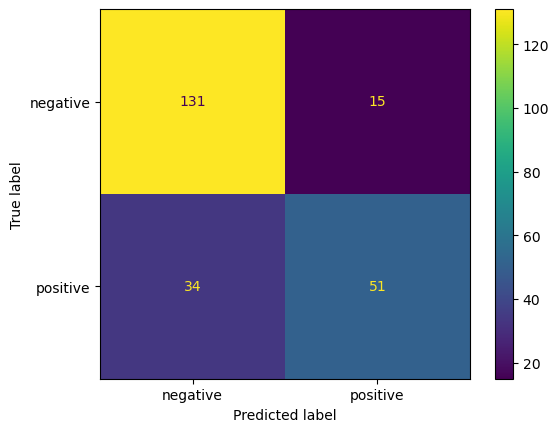

In [13]:
cm = confusion_matrix(y_test, preds, labels=rfc.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_).plot()

No nosso primeiro modelo conseguimos identificar 53 positivos mas não conseguimos classificar outros 32 que eram positivo mas foram identificados como negativo para diabetes. Vamos olhar par ao report do modelo e entendermos melhor a peformance do modelo:

In [14]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

    negative       0.79      0.90      0.84       146
    positive       0.77      0.60      0.68        85

    accuracy                           0.79       231
   macro avg       0.78      0.75      0.76       231
weighted avg       0.79      0.79      0.78       231



Recall: When it actually is a positive case, how often is it correct? TP/Total Positives. TP stands for True Positives, it is the positives the classifier managed to get. In our case there was labeled as positives 52, but there was 85 positives in the dataset.

Precision: When we predicted as positive, how often is it correct? TP/Total Predicted Positives.

F1-score: It is the harmonic mean of precision and recall. Since both are related to each other through the numerator TP. We use the harmonic mean because if we have a zero either in one of the metrics the F1 will be also zero. F1= (2 X precision X recall)/(precison + recall).

Recall: quando realmente é um caso positivo, com que frequência está correto? TP/Total de Positivos. TP significa True Positives, são os positivos que o classificador conseguiu obter. Em nosso caso, foram rotulados como positivos 52, mas havia 85 positivos no conjunto de dados.

Precision: Quando previmos um ponto como positivo, com que frequência estamos corretos? TP/Total de Positivos Previstos.

F1-score: É a média harmônica de precision e recall. Uma vez que ambos estão relacionados entre si através do numerador TP. Usamos a média harmônica porque se tivermos um zero em qualquer uma das métricas o F1 também será zero. F1= (2 X precisão X rechamada)/(precisão + rechamada).

In [15]:
from sklearn.metrics import accuracy_score
errors = []
missclass = []

for i in range(1,200):
    rfc = RandomForestClassifier(n_estimators=i, random_state=1)
    rfc.fit(X_train,y_train)
    preds = rfc.predict(X_test)
    err = 1- accuracy_score(y_test,preds)
    n_missed = np.sum(preds != y_test)
    errors.append(err)
    missclass.append(n_missed)

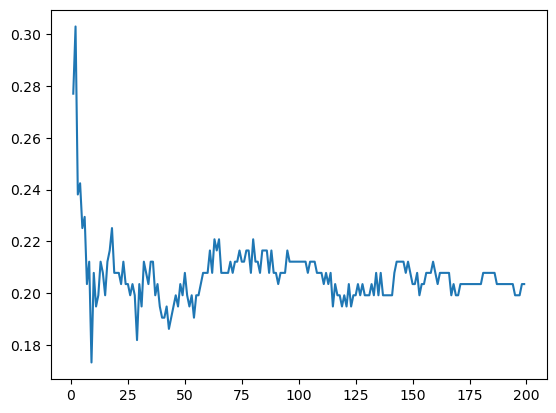

In [16]:
plt.plot(range(1,200),errors)

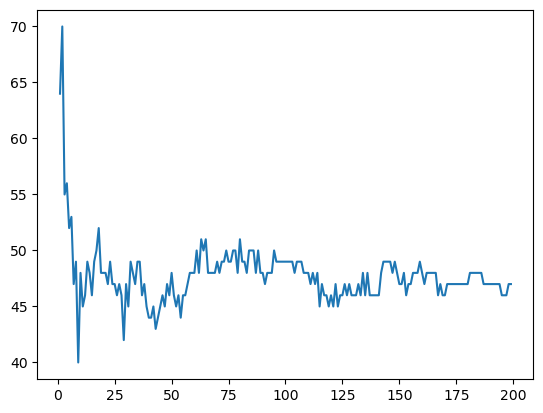

In [17]:
plt.plot(range(1,200),missclass)

Através do plot de missclassification por número de estimadores, podemos perceber que eles são irrelevantes depois de 50 componentes. Então manteremos 100 componentes em todos os modelos e o random_state=1.

## Class Weight (peso das classes)

O primeiro recurso que podemos abordar em um dataset desbalanceado é utilizar pesos diferentes para cada classe no treinamento do modelo. Estes pesos seriam como 'punir' o modelo com mais severidade quando se erra a classificação de uma classe minoritária. Desta forma o modelo compensará a diferença de tamanho dos samples de cada classe. 

O modelo Random Forest já tem em si um parâmetro de class weight que indicamos que é para ele utilizar o peso que compense a diferença de tamanho.

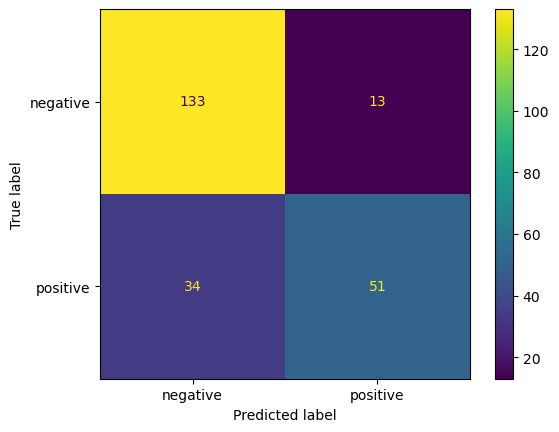

In [18]:
rfc_blcd = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=1)
rfc_blcd.fit(X_train,y_train)
preds_blcd = rfc.predict(X_test)
cm_blcd = confusion_matrix(y_test, preds_blcd, labels=rfc_blcd.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_blcd,display_labels=rfc_blcd.classes_).plot()

In [19]:
print(classification_report(y_test,preds_blcd))

              precision    recall  f1-score   support

    negative       0.80      0.91      0.85       146
    positive       0.80      0.60      0.68        85

    accuracy                           0.80       231
   macro avg       0.80      0.76      0.77       231
weighted avg       0.80      0.80      0.79       231



Tivemos um pequeno aumento (3%) na precisão da classificação positiva, e um aumento de 1% na acurácia. Pela matriz podemos ver que não aumentamos o número de positivos classificados mas melhoramos para negativos.

Um outro método que podemos utilizar para melhorar nossa predição é GridSearch, com o gridsearch podemos passar alguns valores de parametros como n_estimators ou class_weight e ele testará quais parametros entregam o melhor resultado. Por default a métrica utilizada é a acurácia, mas podemos mudar o parametro.

In [107]:
n_estimators = [50,100,200]
weights = [None,"balanced", "balanced_subsample"]
param_grid = {'n_estimators': n_estimators,
             'class_weight': weights}

scoring = make_scorer(f1_score)

rfc = RandomForestClassifier(random_state=1)
grid = GridSearchCV(rfc,param_grid, scoring=scoring)
grid.fit(X_train,y_train)
grid.best_params_

{'class_weight': None, 'n_estimators': 50}

In [52]:
preds_grid = grid.predict(X_test)

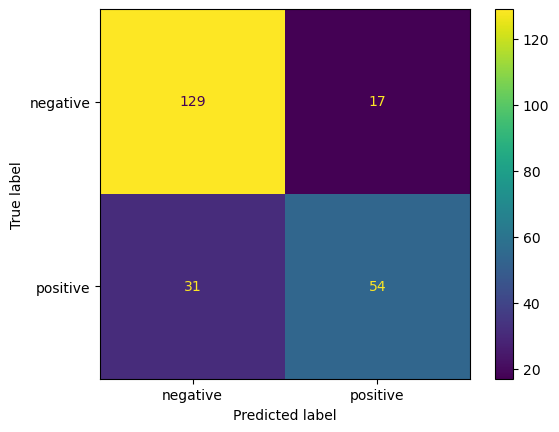

In [53]:
cm_grid = confusion_matrix(y_test, preds_grid, labels=grid.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_grid,display_labels=grid.classes_).plot()

In [54]:
print(classification_report(y_test,preds_grid))

              precision    recall  f1-score   support

    negative       0.81      0.88      0.84       146
    positive       0.76      0.64      0.69        85

    accuracy                           0.79       231
   macro avg       0.78      0.76      0.77       231
weighted avg       0.79      0.79      0.79       231



Tivemos uma melhora no recall e f1-score para a classificação de positivos. E uma piora na classificação de negativos. Este trade-off foi esperado pois tiramos um pouco da 'atenção' do modelo para a classe majoritária. Mas se no contexto do problema é mais importante identificar alguém doente aceitando que alguns são falsos positivos, então o modelo teve uma melhora para o proposto problema.

Agora vamos ver soluções que envolvem transformações nos dados. Estes pré-processamentos necessitam de maior atenção pois se não forem feitas corretamente podem gerar 'data leakage' ou vasamento de dados. Estes vasamentos nada mais são do que captar algumas informações sobre os dados de teste antes de treinarmos o modelo. Por isso devemos aplicar estas transformações depois de 'splitarmos' o dataframe. 

## SMOTE, GridSearch e Pipeline

A primeira transformação que faremos é o método de 'oversampling' ou aumentar sinteticamente a classe minoritária. O parametro para isso através do SMOTE é de gerar estes novos dados gerando uma 'mistura' dos dados da classe, criando novos dados. Esta 'mistura' é como um k-nearest neighbor, ele cria um cluster da classe e gera pontos como que fossem dentro deste cluster. 
Um detalhe importantíssimo é de que iremos utilizar o GridSearchCV, e como o nome sugere ele utiliza Cross Validation na métrica dos melhores parametros. Isto significa que ele cria samples de validação, e se fizermos o oversampling antes de aplicar GridSearchCV isto gerará data leakage. Uma forma de corrigir isto é utilizando **PipeLine**. Pipeline é uma ferramenta que conduz o processo de transformação de dados de forma que evite estes tipos de problemas. Com a ferramenta de Pipeline poderemos gerar um SMOTE para cada validação do CrossValidation. Desta forma ele não vai utilizar o dado de validação durante o treinamento. A biblioteca *imblearn* já possui seu próprio pipeline pensando no tratamento de dados desbalanceados. 

In [106]:
n_estimators = [50,100,200]
weights = [None,"balanced", "balanced_subsample"]

param_grid = {'rfc__n_estimators': n_estimators,
             'rfc__class_weight': weights}
            
scoring = make_scorer(f1_score)

pipeline = Pipeline([
    ('smote', SMOTE()),
    ('rfc', RandomForestClassifier(random_state=1))
])

grid_smote = GridSearchCV(pipeline,param_grid, scoring=scoring)
grid_smote.fit(X_train,y_train)
grid_smote.best_params_

{'rfc__class_weight': None, 'rfc__n_estimators': 50}

In [67]:
print(grid_smote.best_params_)

{'rfc__class_weight': None, 'rfc__n_estimators': 50}


In [68]:
preds_grid_smote = grid_smote.predict(X_test)

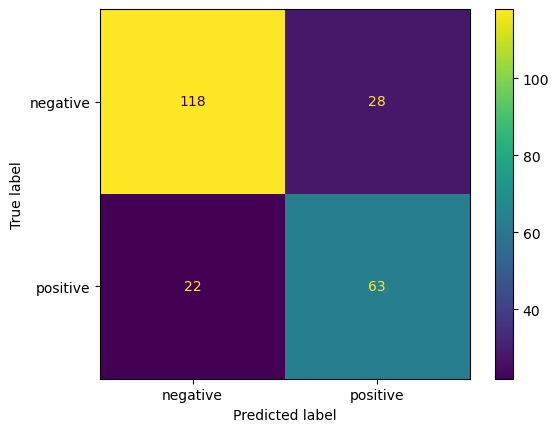

In [69]:
cm_grid_smote = confusion_matrix(y_test, preds_grid_smote, labels=grid_smote.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_grid_smote,display_labels=grid_smote.classes_).plot()

In [70]:
print(classification_report(y_test,preds_grid_smote))

              precision    recall  f1-score   support

    negative       0.84      0.81      0.83       146
    positive       0.69      0.74      0.72        85

    accuracy                           0.78       231
   macro avg       0.77      0.77      0.77       231
weighted avg       0.79      0.78      0.78       231



In [105]:
n_estimators = [50,100,200]
weights = [None,"balanced", "balanced_subsample"]

param_grid = {'rfc__n_estimators': n_estimators,
             'rfc__class_weight': weights}
            
scoring = make_scorer(f1_score)

pipeline = Pipeline([
    ('undersampler', RandomUnderSampler()),
    ('rfc', RandomForestClassifier(random_state=1))
])

grid_undersampler = GridSearchCV(pipeline,param_grid, scoring=scoring)
grid_undersampler.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('undersampler', RandomUnderSampler()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'rfc__class_weight': [None, 'balanced',
                                               'balanced_subsample'],
                         'rfc__n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score))

In [72]:
print(grid_undersampler.best_params_)

{'rfc__class_weight': None, 'rfc__n_estimators': 50}


In [84]:
preds_grid_undersampler = grid_undersampler.predict(X_test)

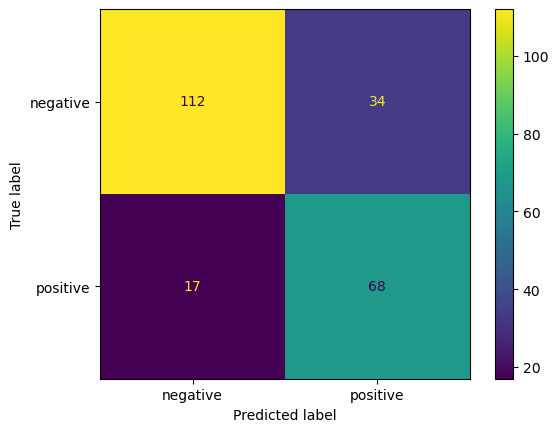

In [85]:
cm_grid_undersampler = confusion_matrix(y_test, preds_grid_undersampler, labels=grid_undersampler.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_grid_undersampler,display_labels=grid_undersampler.classes_).plot()

In [86]:
print(classification_report(y_test,preds_grid_undersampler))

              precision    recall  f1-score   support

    negative       0.87      0.77      0.81       146
    positive       0.67      0.80      0.73        85

    accuracy                           0.78       231
   macro avg       0.77      0.78      0.77       231
weighted avg       0.79      0.78      0.78       231



In [104]:
n_estimators = [50,100,200]
weights = [None,"balanced", "balanced_subsample"]

param_grid = {'rfc__n_estimators': n_estimators,
             'rfc__class_weight': weights}
            
scoring = make_scorer(f1_score)

pipeline = Pipeline([
    ('oversampler', RandomOverSampler()),
    ('rfc', RandomForestClassifier(random_state=1))
])

grid_oversampler = GridSearchCV(pipeline,param_grid, scoring=scoring)
grid_oversampler.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('oversampler', RandomOverSampler()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'rfc__class_weight': [None, 'balanced',
                                               'balanced_subsample'],
                         'rfc__n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score))

In [79]:
print(grid_oversampler.best_params_)

{'rfc__class_weight': None, 'rfc__n_estimators': 50}


In [81]:
preds_grid_oversampler = grid_oversampler.predict(X_test)

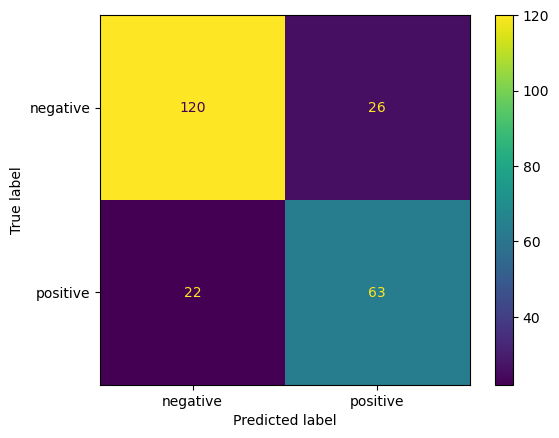

In [82]:
cm_grid_oversampler = confusion_matrix(y_test, preds_grid_oversampler, labels=grid_oversampler.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_grid_oversampler,display_labels=grid_oversampler.classes_).plot()

In [87]:
print(classification_report(y_test,preds_grid_oversampler))

              precision    recall  f1-score   support

    negative       0.85      0.82      0.83       146
    positive       0.71      0.74      0.72        85

    accuracy                           0.79       231
   macro avg       0.78      0.78      0.78       231
weighted avg       0.79      0.79      0.79       231



Não existe um modelo perfeito para todos os problemas, podemos ver que houveram trade-offs entre perder precisão e acurácia na classe negativa para conseguirmos capturar mais pontos positivos. Podemos regular cada parametro e escolher o modelo que melhor 'fit' cada problema. 

## PCA e Clustering
A nivel de curiosidade vamos aplicar algumas técnicas de redução de dimensionalidade e clustering para melhor visualizarmos como é a divisão dos dados. Estás técnicas são úteis para termos uma ideia de qual dificil será para separarmos os dados e delimitarmos os critérios para definição de cada classe.

In [92]:
X = df.drop('Outcome', axis=1)
pca = PCA()
pca.fit(X)
var = pca.explained_variance_ratio_
var[0]

0.8885466345756244

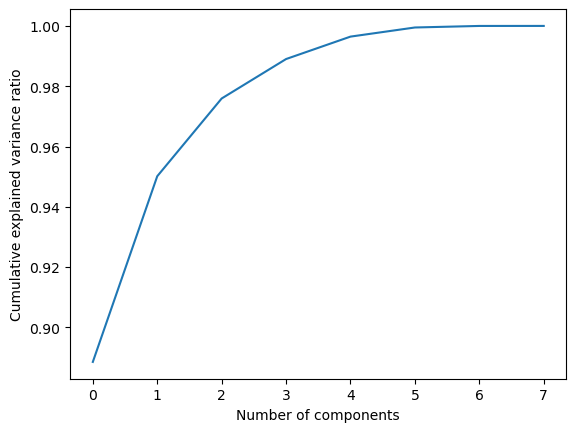

In [93]:
cumsum= np.cumsum(var)

# plot the cumulative variance explained by the principal components
plt.plot(cumsum)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

Grande parte da variância dos dados podem ser explicados com 4 features.

<Axes: >

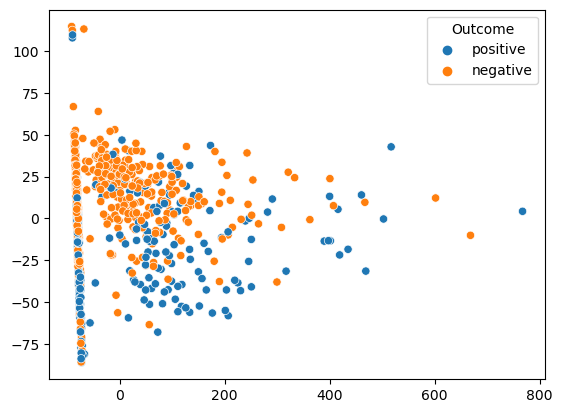

In [94]:
pca = PCA(n_components=4)
pca.fit(X)
pca_data = pca.transform(X)
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1],hue=y)

<Axes: xlabel='MDS1', ylabel='MDS2'>

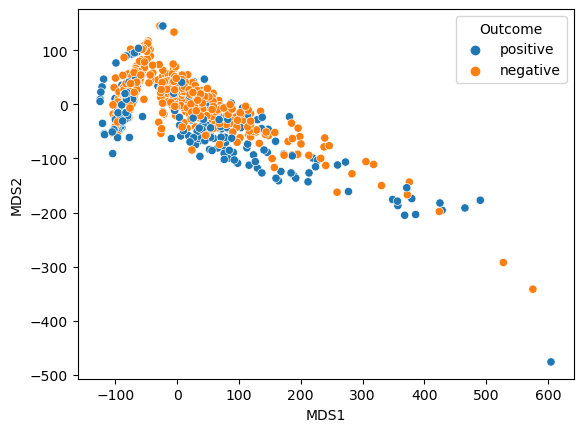

In [96]:
mds = MDS(n_components=2)
mds_result = mds.fit_transform(X)

# create a new DataFrame for the MDS result
df_mds = pd.DataFrame(mds_result, columns=['MDS1', 'MDS2'])

# visualize with Seaborn scatterplot
sns.scatterplot(data=df_mds, x='MDS1', y='MDS2',hue=y)

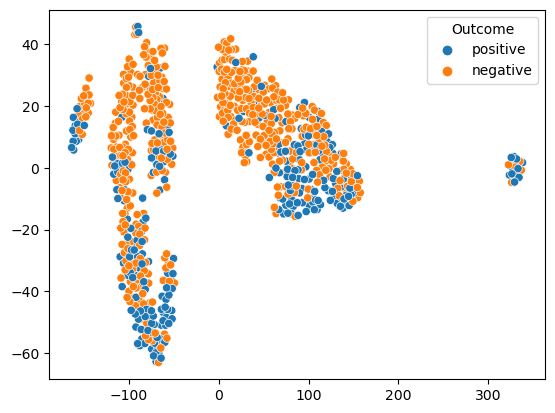

In [103]:
tsne = TSNE(n_components=2, perplexity=40,init='pca')

# Fit the t-SNE model to the PCA-transformed data
tsne_transformed = tsne.fit_transform(pca_data)

sns.scatterplot(x=tsne_transformed[:,0], y=tsne_transformed[:,1],hue=y)
plt.show()